# Min-min Max-max

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [351]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [352]:
df_train_X = pd.read_csv('../Data/train_data.csv')
df_train_Y = pd.read_csv('../Data/train_answers.csv')

In [353]:
df_test = pd.read_csv('../Data/test_data.csv')

In [354]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

In [355]:
X_pred = df_train_X.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                           'Ymin': [min, max, 'mean', 'std', 'median'],
                                           'Xmax': [min, max, 'mean', 'std', 'median'],
                                           'Ymax': [min, max, 'mean', 'std', 'median'],
                                           'userId': ['count', 'sum']})

In [356]:
X_pred = X_pred.merge(df_train_Y, on='itemId', how='inner')

In [357]:
X_pred["iou"] = X_pred[[('Xmin', 'min'),('Ymin', 'min'), ('Xmax', 'max'), ('Ymax', 'max'), 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [358]:
X_pred['iou'].mean()

0.5809800227327839

In [359]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,"(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,1248.666667,85.675745,1255.0,3,2767,198,827,649,1340,0.520083
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,855.333333,3.055050,856.0,3,2767,26,605,433,847,0.723581
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,966.666667,15.631165,969.0,3,2767,233,698,622,920,0.392782
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,459.200000,51.363411,477.0,5,5690,61,368,329,530,0.673495
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,756.833333,137.917971,759.5,6,2820,30,536,328,813,0.359999


### Прогнозирование отклонения

In [360]:
X_pred['Volume'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]) *\
                    (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['Mean_Volume'] = (X_pred[('Xmax', 'mean')] - X_pred[('Xmin', 'mean')]) *\
                    (X_pred[('Ymax', 'mean')] - X_pred[('Ymin', 'mean')])
    
X_pred['Min_Volume'] = abs((X_pred[('Xmax', 'min')] - X_pred[('Xmin', 'max')]) *\
                    (X_pred[('Ymax', 'min')] - X_pred[('Ymin', 'max')]))
    
X_pred['X_Y_ratio'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')])/\
                            (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['X_length'] = X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]
X_pred['Y_length'] = X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')]


In [361]:
X_pred['X_Y_ratio'] = X_pred['X_Y_ratio'].replace(np.inf, 2)
X_pred.fillna(1, inplace=True)

In [362]:
Xmin_dtarg = X_pred['Xmin_true'] - X_pred[('Xmin', 'min')]
Ymin_dtarg = X_pred['Ymin_true'] - X_pred[('Ymin', 'min')]
Xmax_dtarg = X_pred['Xmax_true'] - X_pred[('Xmax', 'max')]
Ymax_dtarg = X_pred['Ymax_true'] - X_pred[('Ymax', 'max')]

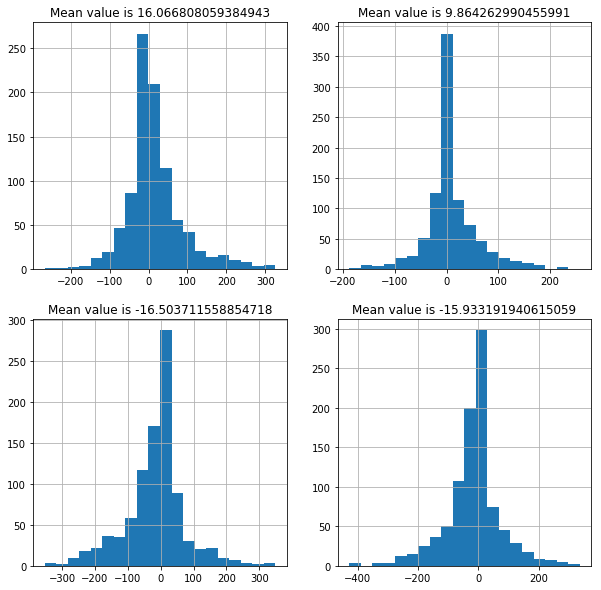

In [363]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
Xmin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmin_dtarg.mean()));

plt.subplot(2, 2, 2)
Ymin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymin_dtarg.mean()));

plt.subplot(2, 2, 3)
Xmax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmax_dtarg.mean()));

plt.subplot(2, 2, 4)
Ymax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymax_dtarg.mean()));

Качество, если добавить константы отклонений к прогнозам

In [364]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,827,649,1340,0.520083,150120,104610.000000,64155,0.863309,360,417
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,605,433,847,0.723581,106145,96189.777778,86292,1.187291,355,299
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,698,622,920,0.392782,219075,191652.333333,160648,1.509186,575,381
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,368,329,530,0.673495,35742,16642.080000,162,1.876812,259,138
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,536,328,813,0.359999,229295,45790.000000,15540,0.626446,379,605


In [365]:
train_data = X_pred.drop(columns=['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'], axis=1)

In [366]:
train_data.columns

Index([    ('Xmin', 'min'),     ('Xmin', 'max'),    ('Xmin', 'mean'),
           ('Xmin', 'std'),  ('Xmin', 'median'),     ('Ymin', 'min'),
           ('Ymin', 'max'),    ('Ymin', 'mean'),     ('Ymin', 'std'),
        ('Ymin', 'median'),     ('Xmax', 'min'),     ('Xmax', 'max'),
          ('Xmax', 'mean'),     ('Xmax', 'std'),  ('Xmax', 'median'),
           ('Ymax', 'min'),     ('Ymax', 'max'),    ('Ymax', 'mean'),
           ('Ymax', 'std'),  ('Ymax', 'median'), ('userId', 'count'),
         ('userId', 'sum'),            'Volume',       'Mean_Volume',
              'Min_Volume',         'X_Y_ratio',          'X_length',
                'Y_length'],
      dtype='object')

### Random Forest

In [367]:
model_Xmin = RandomForestRegressor(n_estimators=500)
preds_Xmin = cross_val_predict(model_Xmin, train_data, Xmin_dtarg, cv=4, n_jobs=-1)

In [368]:
model_Ymin = RandomForestRegressor(n_estimators=500)
preds_Ymin = cross_val_predict(model_Ymin, train_data, Ymin_dtarg, cv=4, n_jobs=-1)

In [369]:
model_Xmax = RandomForestRegressor(n_estimators=500)
preds_Xmax = cross_val_predict(model_Xmax, train_data, Xmax_dtarg, cv=4, n_jobs=-1)

In [370]:
model_Ymax = RandomForestRegressor(n_estimators=500)
preds_Ymax = cross_val_predict(model_Ymax, train_data, Ymax_dtarg, cv=4, n_jobs=-1)

### Score

In [371]:
X_rez = X_pred.copy()

In [372]:
X_rez['Xmin_pred'] = X_rez[('Xmin', 'min')] + preds_Xmin/3
X_rez['Ymin_pred'] = X_rez[('Ymin', 'min')] + preds_Ymin/3
X_rez['Xmax_pred'] = X_rez[('Xmax', 'max')] + preds_Xmax/3
X_rez['Ymax_pred'] = X_rez[('Ymax', 'max')] + preds_Ymax/3


X_rez["iou"] = X_rez[['Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [373]:
X_rez['iou'].mean()

0.582569750891778

### Feature importances

In [374]:
# model_Xmin_fitted = model_Xmin.fit(train_data, Xmin_dtarg)

In [375]:
# feat_emp = pd.Series(dict(zip(train_data.columns, model_Xmin_fitted.feature_importances_))).sort_values(ascending=False)

### Train models on whole data

In [376]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmin_dtarg)

model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymin_dtarg)

model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmax_dtarg)

model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymax_dtarg)

## Test dataset preparation

In [377]:
X_test = df_test.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                        'Ymin': [min, max, 'mean', 'std', 'median'],
                                        'Xmax': [min, max, 'mean', 'std', 'median'],
                                        'Ymax': [min, max, 'mean', 'std', 'median'],
                                        'userId': ['count', 'sum']})

In [378]:
X_test['Volume'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]) *\
                    (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])
    
X_test['Mean_Volume'] = (X_test[('Xmax', 'mean')] - X_test[('Xmin', 'mean')]) *\
                (X_test[('Ymax', 'mean')] - X_test[('Ymin', 'mean')])
    
X_test['Min_Volume'] = abs((X_test[('Xmax', 'min')] - X_test[('Xmin', 'max')]) *\
                    (X_test[('Ymax', 'min')] - X_test[('Ymin', 'max')]))
    
    
X_test['X_Y_ratio'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')])/\
                            (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])    
    
X_test['X_length'] = X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]
X_test['Y_length'] = X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')]

In [379]:
X_test['X_Y_ratio'] = X_test['X_Y_ratio'].replace(np.inf, 2)
X_test.fillna(1, inplace=True)

In [380]:
preds_Xmin = model_Xmin.predict(X_test)
preds_Ymin = model_Ymin.predict(X_test)
preds_Xmax = model_Xmax.predict(X_test)
preds_Ymax = model_Ymax.predict(X_test)

In [381]:
X_test['Xmin_pred'] = X_test[('Xmin', 'min')] + preds_Xmin/3
X_test['Ymin_pred'] = X_test[('Ymin', 'min')] + preds_Ymin/3
X_test['Xmax_pred'] = X_test[('Xmax', 'max')] + preds_Xmax/3
X_test['Ymax_pred'] = X_test[('Ymax', 'max')] + preds_Ymax/3

In [382]:
X_test['itemId'] = X_test.index
X_test = X_test[['itemId', 'Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred']]

In [385]:
X_test.to_csv('../Submits/submit12.csv', header=False, index=False)

In [386]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,827,649,1340,0.520083,150120,104610.000000,64155,0.863309,360,417
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,605,433,847,0.723581,106145,96189.777778,86292,1.187291,355,299
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,698,622,920,0.392782,219075,191652.333333,160648,1.509186,575,381
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,368,329,530,0.673495,35742,16642.080000,162,1.876812,259,138
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,536,328,813,0.359999,229295,45790.000000,15540,0.626446,379,605


In [387]:
X_test.head( )

,itemId,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred
,,,,,
itemId,,,,,
18,18,120.792000,631.638000,763.995333,1138.854000
19,19,29.437333,563.756000,123.405333,725.786000
33,33,28.006000,382.538000,405.972667,651.706000
62,62,51.944667,828.746667,628.574000,1260.575333
114,114,44.140667,570.957333,221.203333,764.688000


## Test prediction

In [18]:
test_pred = df_test.groupby('itemId').agg({'Xmin': min,
                                              'Ymin': min,
                                              'Xmax': max,
                                              'Ymax': max})

In [29]:
test_pred['itemId'] = test_pred.index
test_pred = test_pred[['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]

In [30]:
test_pred.to_csv('../Submits/submit3.csv', header=False, index=False)

In [31]:
test_pred

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,126,634,764,1132
19,19,27,559,119,729
33,33,21,380,414,652
62,62,35,824,639,1262
114,114,41,570,216,780
146,146,17,211,643,1118
156,156,74,802,160,887
163,163,21,317,213,465
164,164,4,146,401,681
